In [ ]:
!pip install mne wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [ ]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
SUBJECT_TRAIN_NO = 14
SUBJECT_TEST_NO = 5
missed_subjects = [36, 39, 52, 68, 69, 78, 79]
missed_stage_subjects = [4, 10, 32, 33, 34, 41, 57, 64, 72, 73, 74, 75]  # stage 3 and 4 are not available in these subjects
subjects_train = []
subjects_test = []

# for i in range(52):
#     if i == 39 or i == 36:
#         continue
#     subjects.append(i)

for i in range(SUBJECT_TRAIN_NO):  # train subjects indexes
    if i in missed_subjects:
        continue
    if i in missed_stage_subjects:
        continue
    subjects_train.append(i)

for i in range(SUBJECT_TRAIN_NO, SUBJECT_TRAIN_NO + SUBJECT_TEST_NO + 1):  # test subject indexes
    if i in missed_subjects:
        continue
    if i in missed_stage_subjects:
        continue
    subjects_test.append(i)

test_len = len(subjects_test)
train_len = len(subjects_train)
print(train_len, test_len)
subjects_train_psg = []
subjects_train_hyp = []
subjects_test_psg = []
subjects_test_hyp = []

subject_train_files = fetch_data(subjects=subjects_train, recording=[1])
subject_test_files = fetch_data(subjects=subjects_test, recording=[1])
#subject_train_files = fetch_data(subjects=subjects_train, recording=[1],path="/content/drive/MyDrive/sleep_edf/") #drive için
#subject_test_files = fetch_data(subjects=subjects_test, recording=[1],path="/content/drive/MyDrive/sleep_edf/")

12 6


In [ ]:
# select PSG urls for train
for x in range(train_len):
    subjects_train_psg.append(subject_train_files[x][0])

# select hypnogram urls for train
for x in range(train_len):
    subjects_train_hyp.append(subject_train_files[x][1])

# select psg urls for test
for x in range(test_len):
    subjects_test_psg.append(subject_test_files[x][0])

# select hypnogram urls for test
for x in range(test_len):
    subjects_test_hyp.append(subject_test_files[x][1])

In [ ]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6,
}
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6,
}

In [ ]:
epochs_train_list = []
epochs_test_list = []

In [ ]:
# epochları oluştur train için
for psg_url, hyp_url in zip(subjects_train_psg, subjects_train_hyp):
    # PSG dosyasını oku
    raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)

    # Hypnogram dosyasını oku ve zaman aralığını güncelle
    annot_data = mne.read_annotations(hyp_url)
    annot_data.crop(annot_data[1]["onset"] - 30 * 60, annot_data[-2]["onset"] + 30 * 60)

    # Annotations'ları raw veri nesnesine ekle
    raw_data.set_annotations(annot_data, emit_warning=False)

    # Events oluştur
    events, _ = mne.events_from_annotations(raw_data, event_id=annotation_desc_2_event_id, chunk_duration=30.0)

    # Epochs oluştur
    epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_id, tmin=0.0, tmax=29.99,
                        baseline=None, on_missing="ignore")

    # Listeye ekle
    epochs_train_list.append(epochs)

Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4001E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4011E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 sec

/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4021E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8411999  =      0.000 ... 84119.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4031E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
952 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4051E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4061E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
843 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4071E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
976 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4081E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8387999  =      0.000 ... 83879.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1134 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4091E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1132 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4111E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7925999  =      0.000 ... 79259.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
928 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4121E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8357999  =      0.000 ... 83579.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1783 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4131E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8441999  =      0.000 ... 84419.990 secs...


/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-2608961809.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1028 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
# epochları oluştur test için
for psg_url, hyp_url in zip(subjects_test_psg, subjects_test_hyp):
    # PSG dosyasını oku
    raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)

    # Hypnogram dosyasını oku ve zaman aralığını güncelle
    annot_data = mne.read_annotations(hyp_url)
    annot_data.crop(annot_data[1]["onset"] - 30 * 60, annot_data[-2]["onset"] + 30 * 60)

    # Annotations'ları raw veri nesnesine ekle
    raw_data.set_annotations(annot_data, emit_warning=False)

    # Events oluştur
    events, _ = mne.events_from_annotations(raw_data, event_id=annotation_desc_2_event_id, chunk_duration=30.0)

    # Epochs oluştur
    epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_id, tmin=0.0, tmax=29.99,
                        baseline=None, on_missing="ignore")

    # Listeye ekle
    epochs_test_list.append(epochs)


Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4141E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...


/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1004 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4151E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7859999  =      0.000 ... 78599.990 secs...


/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
952 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4161E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7877999  =      0.000 ... 78779.990 secs...


/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1144 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4171E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8225999  =      0.000 ... 82259.990 secs...


/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1002 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4181E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...


/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
964 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/sleep_edf/physionet-sleep-data/SC4191E0-PSG.edf...
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...


/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)
/tmp/ipython-input-1623288001.py:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(psg_url, stim_channel="Event marker", infer_types=True, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1535 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
def epochs_list_to_xy(epochs_list, target_channel="Fpz-Cz"):
    X_list = []
    y_list = []

    for epochs in epochs_list:
        data = epochs.get_data(verbose=False)  # (n_epochs, n_channels, n_times)
        ch_names = epochs.ch_names

        # Hedef kanalı bul
        if target_channel in ch_names:
            ch_idx = ch_names.index(target_channel)
        else:
            # Hedef kanal yoksa, uyarı ver ve ilk kanalı kullan
            print(f"[Uyarı] {target_channel} bu kayıtta yok. Kullanılan kanal: {ch_names[0]}")
            ch_idx = 0

        # Sadece seçilen kanalı al -> (n_epochs, n_times)
        data_ch = data[:, ch_idx, :]

        # Event id'ler (1..6) -> 0..5
        labels = epochs.events[:, 2] - 1

        X_list.append(data_ch)
        y_list.append(labels)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    return X, y


In [ ]:
X_train, y_train = epochs_list_to_xy(epochs_train_list, target_channel="Fpz-Cz")
X_test, y_test   = epochs_list_to_xy(epochs_test_list,  target_channel="Fpz-Cz")

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :",  y_test.shape)


X_train: (12417, 3000) y_train: (12417,)
X_test : (6601, 3000) y_test : (6601,)


In [ ]:
# Epoch bazlı z-score normalizasyon
X_train = (X_train - X_train.mean(axis=1, keepdims=True)) / (X_train.std(axis=1, keepdims=True) + 1e-8)
X_test  = (X_test  - X_test.mean(axis=1,  keepdims=True)) / (X_test.std(axis=1,  keepdims=True) + 1e-8)

# Keras için (N, T, 1) şekline getir
X_train_dl = X_train[..., np.newaxis]
X_test_dl  = X_test[..., np.newaxis]

print("X_train_dl:", X_train_dl.shape)
print("X_test_dl :", X_test_dl.shape)


X_train_dl: (12417, 3000, 1)
X_test_dl : (6601, 3000, 1)


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

num_classes = len(np.unique(y_train))
print("Sınıf sayısı:", num_classes)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_dl, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

print("Train DL :", X_tr.shape, y_tr.shape)
print("Val DL   :", X_val.shape, y_val.shape)
print("Test DL  :", X_test_dl.shape, y_test.shape)

y_tr_cat  = keras.utils.to_categorical(y_tr,  num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat= keras.utils.to_categorical(y_test, num_classes)


Sınıf sayısı: 6
Train DL : (9933, 3000, 1) (9933,)
Val DL   : (2484, 3000, 1) (2484,)
Test DL  : (6601, 3000, 1) (6601,)


In [ ]:
tf.keras.backend.clear_session()

def build_cnn_bilstm_model(input_shape, num_classes):
    inp = keras.Input(shape=input_shape)  # (T,1)

    x = layers.Conv1D(64, 7, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 7, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out)

input_shape = X_tr.shape[1:]  # (T,1)
model = build_cnn_bilstm_model(input_shape, num_classes)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3000, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1500, 128)      │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 750, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 750, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,086 (680.02 KB)

 Trainable params: 174,086 (680.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

class_weight = {
    0: 1.0,  # W
    1: 3.0,  # N1 <-- kritik
    2: 1.0,  # N2
    3: 1.0,  # N3
    4: 1.0,  # N4
    5: 1.0,  # REM
}

history = model.fit(
    X_tr.astype("float32"), y_tr_cat,
    validation_data=(X_val.astype("float32"), y_val_cat),
    epochs=15,
    batch_size=64,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.4093 - loss: 1.8122 - val_accuracy: 0.5242 - val_loss: 1.2299
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.4532 - loss: 1.5804 - val_accuracy: 0.5729 - val_loss: 1.1155
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.5389 - loss: 1.3070 - val_accuracy: 0.6534 - val_loss: 0.8827
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.6369 - loss: 1.0789 - val_accuracy: 0.6787 - val_loss: 0.8061
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.6516 - loss: 1.0326 - val_accuracy: 0.6824 - val_loss: 0.7886
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.6769 - loss: 0.9529 - val_accuracy: 0.6860 - val_loss: 0.7706
Epoch 7/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.6847 - loss: 0.9363 - val_accuracy: 0.7218 - val_loss: 0.6965
Epoch 8/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.7033 - loss: 0.9051 - val_accu

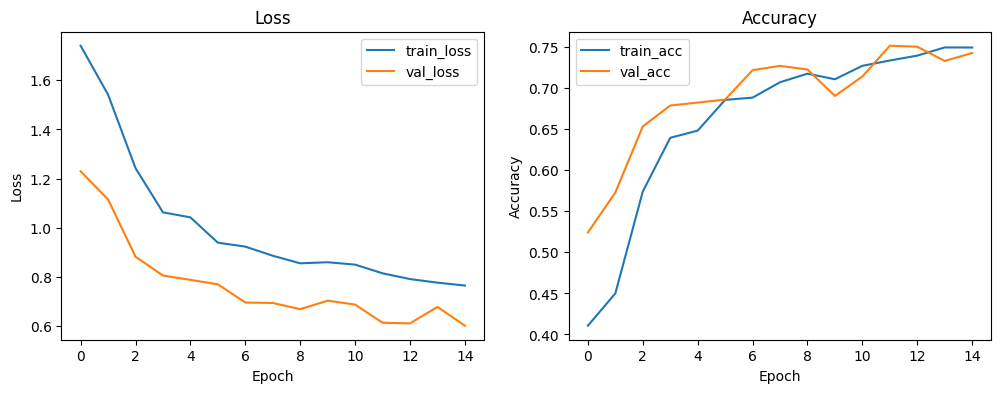

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

plot_history(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(X_test_dl, y_test_cat, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


Test loss: 0.7883, Test accuracy: 0.7023


207/207 ━━━━━━━━━━━━━━━━━━━━ 67s 320ms/step
               precision    recall  f1-score   support

Sleep stage W       0.83      0.79      0.81      1077
Sleep stage 1       0.21      0.59      0.31       293
Sleep stage 2       0.75      0.89      0.82      2755
Sleep stage 3       0.65      0.49      0.56       732
Sleep stage 4       0.85      0.51      0.64       377
Sleep stage R       0.83      0.44      0.57      1367

     accuracy                           0.70      6601
    macro avg       0.69      0.62      0.62      6601
 weighted avg       0.75      0.70      0.70      6601



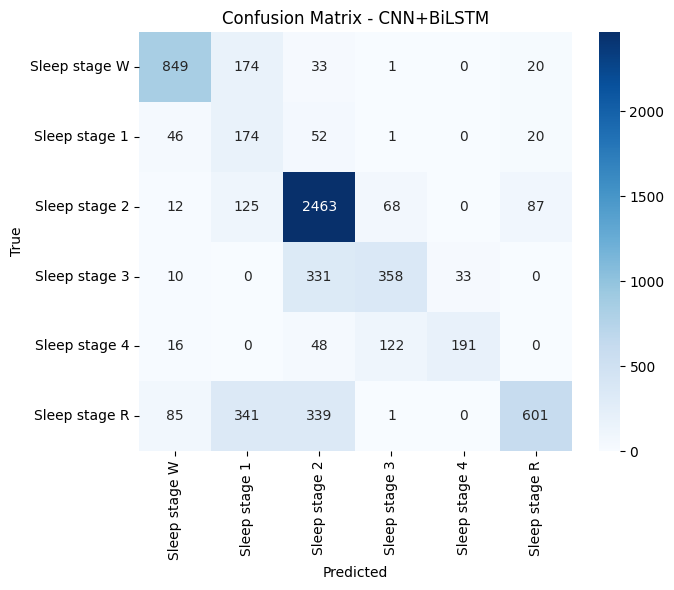

In [ ]:
y_pred_proba = model.predict(X_test_dl)
y_pred = np.argmax(y_pred_proba, axis=1)

class_names = [
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
]

print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN+BiLSTM")
plt.tight_layout()
plt.show()
